In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage.feature import local_binary_pattern
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

In [2]:
DATASET_DIR = "PlantVillage"
IMAGE_SIZE = (256, 256)
LBP_RADIUS = 1
LBP_POINTS = 8 * LBP_RADIUS
LBP_METHOD = 'uniform'

In [ ]:
def extract_color_features(image):
    features = []
    for i in range(3):
        features.append(np.mean(image[:, :, i]))
        features.append(np.std(image[:, :, i]))
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    for i in range(3):
        features.append(np.mean(hsv[:, :, i]))
        features.append(np.std(hsv[:, :, i]))
    hist = cv2.calcHist([hsv], [0, 1, 2], None, [8, 8, 8], [0, 180, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    features.extend(hist)
    return features

In [4]:
def extract_texture_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(gray, LBP_POINTS, LBP_RADIUS, method=LBP_METHOD)
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, LBP_POINTS + 3), range=(0, LBP_POINTS + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)
    return hist.tolist()

In [5]:
def extract_shape_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        return [0, 0, 0]
    c = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(c)
    aspect_ratio = float(w) / h
    area = cv2.contourArea(c)
    rect_area = w * h
    extent = float(area) / rect_area if rect_area != 0 else 0
    hull = cv2.convexHull(c)
    hull_area = cv2.contourArea(hull)
    solidity = float(area) / hull_area if hull_area != 0 else 0
    return [aspect_ratio, extent, solidity]

In [6]:
data = []
labels = []
for folder in os.listdir(DATASET_DIR):
    folder_path = os.path.join(DATASET_DIR, folder)
    if not os.path.isdir(folder_path):
        continue
    for file in os.listdir(folder_path):
        img_path = os.path.join(folder_path, file)
        image = cv2.imread(img_path)
        if image is None:
            continue
        image = cv2.resize(image, IMAGE_SIZE)
        color_feats = extract_color_features(image)
        texture_feats = extract_texture_features(image)
        shape_feats = extract_shape_features(image)
        features = color_feats + texture_feats + shape_feats
        data.append(features)
        labels.append(folder)

In [7]:
df = pd.DataFrame(data)
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)

X_train, X_test, y_train, y_test = train_test_split(
    df, labels_encoded, test_size=0.2, random_state=42, stratify=labels_encoded
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [8]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

knn = KNeighborsClassifier()

grid_search = GridSearchCV(knn, param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


,estimator,KNeighborsClassifier()
,param_grid,"{'metric': ['euclidean', 'manhattan', ...], 'n_neighbors': [3, 5, ...], 'weights': ['uniform', 'distance']}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_neighbors,3


In [9]:
print("Best Parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

Best Parameters: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}


In [10]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

Accuracy: 0.9544573643410853

Classification Report:
                                              precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.97      0.93      0.95       199
                     Pepper__bell___healthy       0.95      0.96      0.95       296
                      Potato___Early_blight       0.98      0.99      0.98       200
                       Potato___Late_blight       0.94      0.94      0.94       200
                           Potato___healthy       0.93      0.90      0.92        30
                      Tomato_Bacterial_spot       0.97      0.96      0.96       426
                        Tomato_Early_blight       0.94      0.86      0.90       200
                         Tomato_Late_blight       0.97      0.91      0.94       382
                           Tomato_Leaf_Mold       0.95      0.97      0.96       190
                  Tomato_Septoria_leaf_spot       0.91      0.95      0.93       354
Tomato_Spi

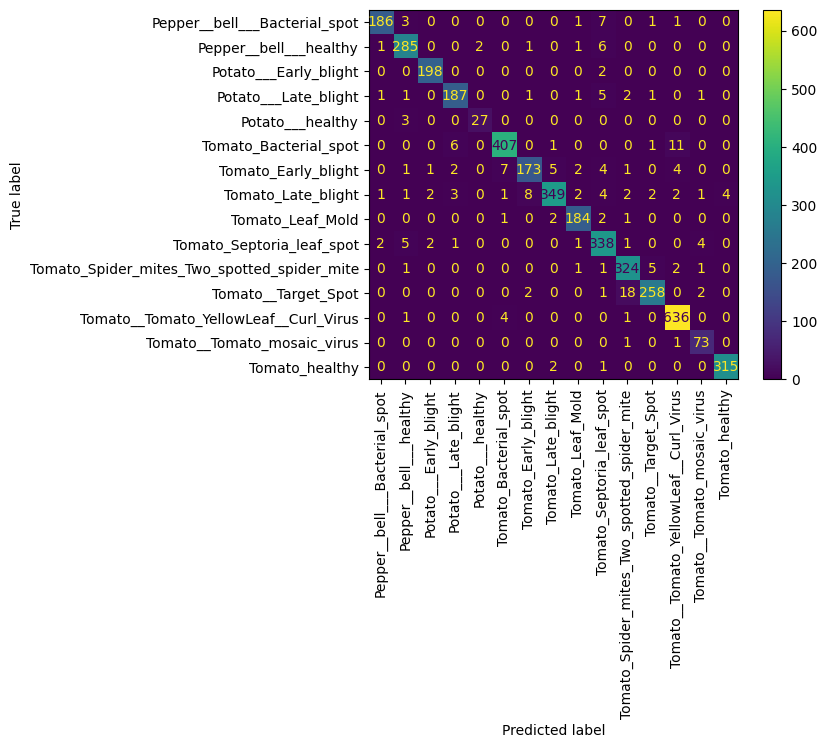

In [11]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(xticks_rotation=90, cmap="viridis")
plt.show()

In [13]:
import joblib

joblib.dump(best_model, 'KNN_Model')
joblib.dump(le, 'KNN_Label_Encoder')

['KNN_Label_Encoder']

In [14]:
def preprocess_and_classify_image(image_path, model, label_encoder):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Could not read image: {image_path}")
    
    img = cv2.resize(img, IMAGE_SIZE)

    color_features = extract_color_features(img)
    texture_features = extract_texture_features(img)
    shape_features = extract_shape_features(img)

    features = np.hstack([color_features, texture_features, shape_features])

    features = features.reshape(1, -1)
    pred = model.predict(features)[0]
    pred_proba = model.predict_proba(features)[0]

    predicted_class = label_encoder.inverse_transform([pred])[0]

    return predicted_class, pred_proba

In [ ]:
print(f"S No. \t\t Actual Class \t\t\t Predicted Class")
i=1
for folder in os.listdir('Custom_Input'):
    folder_path = os.path.join('Custom_Input', folder)

    if not os.path.isdir(folder_path):
        continue
    for files in os.listdir(folder_path):
        image_path = os.path.join(folder_path, files)
        pred_class, prob = preprocess_and_classify_image(image_path, best_model, le)

        print(f"{i} \t\t {folder} \t\t\t {pred_class}")
        i+=1
        


S No. 		 Actual Class 			 Predicted Class


NameError: name 'INPUT_DIR' is not defined